### Домашнее задание по лекции "Работа с текстом" DLL

1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Визуаилизировать embeddings по самым частотным словам (top 1000)
4. Найти самые близкие слова для:
   - homer - marge + bart;
   - bart - lisa + school;
   - marge - homer + home
5. попробовать построить классификатор bart/lisa с использованием этих эмбеддингов

#### 1. Скачать датасет с фразами Cимпсонов
https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data

In [ ]:
!wget https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip
!unzip simpsons_script_lines.csv.zip

#### 2. Обучить Word2Vec на фразах персонажей

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [7]:
# simpsons = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False)
simpsons = pd.read_csv('data.csv')
simpsons=simpsons.iloc[:, 1:].sort_values(by='id')
simpsons.tail(5)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
9947,158218,568,108,Lisa Simpson: (TALKING OVER EACH OTHER) Cook a...,779000,True,9,5.0,Lisa Simpson,Simpson Home,Cook all the tater tots! / There were too many...,cook all the tater tots there were too many to...,22.0
9948,158222,568,112,Lisa Simpson: (DISAPPOINTED GASP) I can't beli...,803000,True,9,5.0,Lisa Simpson,Simpson Home,I can't believe you're gambling.,i cant believe youre gambling,5.0
9949,158228,568,118,Lisa Simpson: (PROUD) I know how much to tip a...,824000,True,9,5.0,Lisa Simpson,Simpson Home,I know how much to tip a waiter.,i know how much to tip a waiter,8.0
9945,158248,568,138,Lisa Simpson: --but she hasn't come home yet a...,943000,True,9,5.0,Lisa Simpson,Simpson Home,--but she hasn't come home yet and we're worri...,--but she hasnt come home yet and were worried...,12.0
9950,158250,568,140,Lisa Simpson: Mom's counting cards at the casino!,947000,True,9,5.0,Lisa Simpson,Simpson Home,Mom's counting cards at the casino!,moms counting cards at the casino,6.0


In [8]:
phrases = simpsons['normalized_text'].to_list()

episodes = simpsons['episode_id'].unique()
len(episodes) 

562

In [9]:
# соединим список фраз в текст без цифр
def phrases_to_text(phrases):
    text = ''
    number_digits = 0
    for i in range(len(phrases)):
        if not str(phrases[i]).isdigit():
            text += ' ' + str(phrases[i])
        else:
            number_digits += 1
    if number_digits != 0:
        print('Число удаленных цифр в тексте', number_digits)
  
    return text

In [10]:
query = phrases_to_text(phrases)

Число удаленных цифр в тексте 1


In [11]:
# длина словаря
len(set(query.split()))  

10849

In [12]:
# Удалим редкие слова (встречаются 1 раз) из текста
cnt = Counter(query.split())

In [13]:
# список редких слов
rare_words = []
for key in cnt:
    if cnt[key] == 1:
        rare_words.append(key)

        
rare_words = set(rare_words)
querywords = query.split()
resultwords  = [word for word in querywords if word not in rare_words]
   

len(resultwords), len(rare_words)

(95134, 6177)

In [14]:
vocabulary = set(resultwords)
print('Длина словаря:', len(vocabulary))
print(f'Словарь сократился на: {len(rare_words)} слов')

Длина словаря: 4672
Словарь сократился на: 6177 слов


In [15]:
w2i = {w: i for i, w in enumerate(vocabulary)}
i2w = {i: w for i, w in enumerate(vocabulary)}

In [16]:
# Создаём датасет для тренировки CBOW 
# Выделим отдельные эпизоды,как объединенные единым смыслом участки текста для создания правильного контекста
# context window size is four

def create_cbow_dataset(df, rare_words):
    episodes = df['episode_id'].unique()
    data = []
    for episode in episodes:
        ep_frame = df[df['episode_id'] == episode]
        ep_frame =  ep_frame.sort_values(by = 'id')
        episode_phrases = ep_frame['normalized_text'].to_list()
        text = phrases_to_text(episode_phrases)
        querywords = text.split()
        text  = [word for word in querywords if word not in rare_words]

        for i in range(4, len(text) - 4):
            context = [text[i - 4],text[i - 3], text[i - 2],text[i - 1],
                       text[i + 1], text[i + 2],text[i + 3], text[i + 4]]
            target = text[i]
            data.append((context, target))
    return data

In [17]:
cbow_train = create_cbow_dataset(simpsons, rare_words)

Число удаленных цифр в тексте 1


In [18]:
len(cbow_train)

90638

In [19]:
print('cbow sample', cbow_train[21112])

cbow sample (['mr', 'bush', 'claims', 'dad', 'wouldnt', 'have', 'voted', 'for'], 'i')


In [20]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((inputs.shape[0], -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs
     

# Подготовим обучающий массив для превращение слов в контекст и таргет (Torch tensor ) из наборов  cbow_train
TRAIN = []
for context, target in cbow_train:
    ctx_idxs = [w2i[w] for w in context]
    ctx_idxs = torch.LongTensor(ctx_idxs)
    TRAIN.append((ctx_idxs,torch.LongTensor([w2i[target]])))

    
TRAIN[4]

(tensor([1903, 3877, 2271, 3489,  881,  881, 2610,  811]), tensor([1710]))

In [21]:
len(TRAIN)

90638

In [22]:
BATCH_SIZE = 900
train_iter = torch.utils.data.DataLoader(TRAIN, batch_size=BATCH_SIZE, shuffle = True)
     

embd_size = 300
learning_rate = 2.0
n_epoch = 50
vocab_size = len(vocabulary)
CONTEXT_SIZE = 4  # 4 words to the left, 4 to the right

hidden_size = 300
losses = []
loss_fn = nn.NLLLoss()
model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
model #.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
ep = [i for i in range(n_epoch)]
for epoch in ep:
    print(f'===========epoch=={epoch}===========')
    total_loss = .0
    for context, target in train_iter:
        context,target = context, target #context .cuda(), target.cuda()
        #print(context.shape)
        #context = context.unsqueeze(0)
        #print(context.shape)
        #print(target.shape)
        model.zero_grad()
        log_probs = model(context)
        #print('OUTPUT', log_probs.shape)
        target = target.squeeze()
        #print('TARGET',target.shape)
        loss = loss_fn(log_probs, target)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'loss = {total_loss}')
    losses.append(total_loss)

===========epoch==0===========
loss = 633.2879858016968
===========epoch==1===========
loss = 523.9469666481018
===========epoch==2===========
loss = 455.98755168914795
===========epoch==3===========
loss = 387.6575679779053
===========epoch==4===========
loss = 319.2323668003082
===========epoch==5===========
loss = 251.23455202579498
===========epoch==6===========
loss = 190.29838931560516
===========epoch==7===========
loss = 131.01603186130524
===========epoch==8===========
loss = 81.14532804489136
===========epoch==9===========
loss = 41.66152584552765
===========epoch==10===========
loss = 15.587170854210854
===========epoch==11===========
loss = 4.41226826608181
===========epoch==12===========
loss = 1.6614194167777896
===========epoch==13===========
loss = 1.1415517618879676
===========epoch==14===========
loss = 0.9289647825062275
===========epoch==15===========
loss = 0.8119664755649865
===========epoch==16===========
loss = 0.7277227910235524
===========epoch==17===========


In [23]:
sample_to_test = [cbow_train[random.randint(1,len(cbow_train))] for i in range(900)] 

In [24]:
model.cpu()

CBOW(
  (embeddings): Embedding(4672, 300)
  (linear1): Linear(in_features=2400, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=4672, bias=True)
)

In [25]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))
        ctx_var = ctx_var.unsqueeze(0)
        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted.item()]
        if predicted_word == target:
            correct_ct += 1
        print('label :', target)
        print('predicted:', predicted_word)
             
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [26]:
test_cbow(sample_to_test,model)

====Test CBOW===
label : my
predicted: my
label : learned
predicted: learned
label : teacher
predicted: teacher
label : you
predicted: you
label : you
predicted: you
label : joe
predicted: joe
label : your
predicted: your
label : futile
predicted: futile
label : dad
predicted: dad
label : same
predicted: same
label : our
predicted: our
label : me
predicted: me
label : the
predicted: the
label : you
predicted: you
label : him
predicted: him
label : eep
predicted: eep
label : a
predicted: a
label : you
predicted: you
label : have
predicted: have
label : books
predicted: books
label : faced
predicted: faced
label : the
predicted: the
label : and
predicted: and
label : i
predicted: i
label : can
predicted: can
label : saying
predicted: saying
label : with
predicted: with
label : everything
predicted: everything
label : bald
predicted: bald
label : convertible
predicted: convertible
label : of
predicted: of
label : look
predicted: look
label : ever
predicted: ever
label : more
predicted: mo

<Figure size 640x480 with 0 Axes>

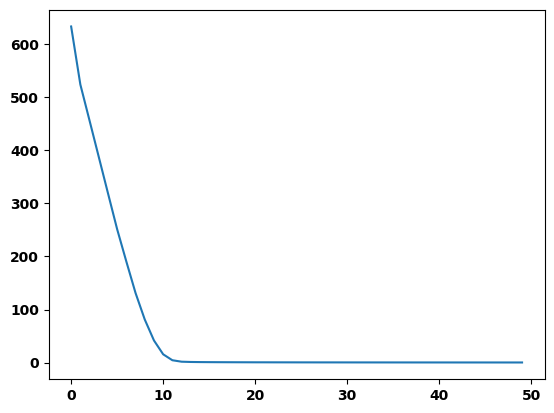

In [27]:
def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(losses, 'CBOW Losses')

#### 3. Визуализировать embeddings по самым частотным словам (top 1000)

In [34]:
from gensim.models import Word2Vec
from collections import Counter
from sklearn.decomposition import PCA
from pylab import rcParams
rcParams['figure.figsize'] = 20,12

In [39]:
phrases = simpsons['normalized_text'].to_list()

sentences = []
for phrase in phrases:
    phrase_words = [word for word in str(phrase).split() if word not in rare_words]
    sentences.append(phrase_words)

sentences[:4]  

[['but',
  'i',
  'really',
  'want',
  'a',
  'pony',
  'and',
  'ive',
  'been',
  'really',
  'really',
  'good',
  'this',
  'year'],
 ['nice', 'try', 'dad'],
 ['ooh'],
 ['i', 'do']]

In [63]:
# train model
model = Word2Vec(sentences, min_count=2) #, vector_size=100, alpha=0.025)
# summarize the loaded model
print(model)
# summarize vocabulary
# words = list(model.wv.vocab)
words = list(model.wv.key_to_index)
#print(words)
# access vector for one word
print(model.wv.get_vector('sentence'))
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)
     
Word2Vec(vector_size=100, alpha=0.025)

Word2Vec<vocab=4672, vector_size=100, alpha=0.025>
[-2.39773989e-02  3.51573303e-02 -1.18486220e-02 -1.64923649e-02
  5.47893206e-03 -7.21621886e-02  2.46457979e-02  1.06045410e-01
 -5.45882843e-02 -4.03402112e-02 -2.56265122e-02 -7.11089000e-02
 -1.13066914e-03  2.03566961e-02 -6.14995079e-05 -1.70915667e-02
  1.58612337e-02 -4.00317758e-02 -3.31767723e-02 -1.24543361e-01
  4.72211018e-02  2.17740182e-02  5.09683490e-02 -1.65931880e-02
 -2.43435279e-02  1.13540301e-02 -4.57543693e-02 -2.40958910e-02
 -4.97927070e-02 -5.29058045e-03  5.86561561e-02 -5.81853371e-03
  3.16175297e-02 -7.92553276e-02 -2.60078739e-02  5.38561530e-02
  7.66122760e-03 -1.85677987e-02 -2.32654903e-02 -1.08406574e-01
  2.54483288e-03 -6.43953159e-02 -2.80607659e-02 -2.98637967e-03
  3.25919464e-02 -2.85482146e-02 -3.91620360e-02  4.62713232e-03
  3.40533182e-02  2.79957503e-02  4.96380553e-02 -3.95196639e-02
 -8.34219530e-03 -1.61814950e-02 -1.89276580e-02  2.42057554e-02
  1.69027280e-02 -1.81573145e-02 -6.238

Число удаленных цифр в тексте 1
(150, 100)


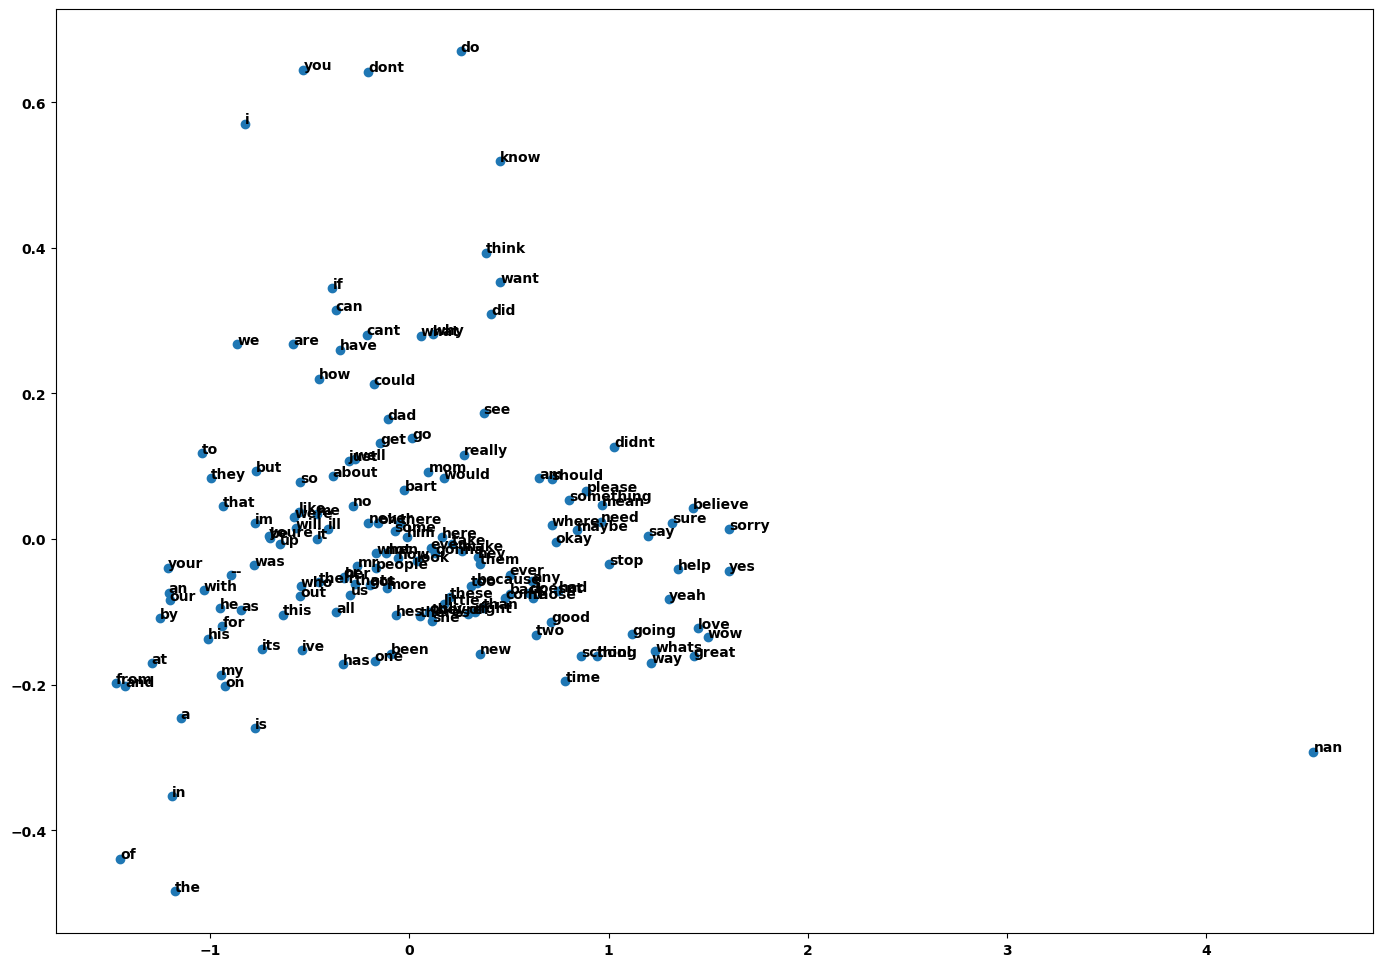

In [180]:
def plot_most_common_word(df, model, rare_words, n = 1000):
    phrases = df['normalized_text'].to_list()
    text = phrases_to_text(phrases)
    querywords = text.split()
    resultwords  = [word for word in querywords if word not in rare_words]
    cntr = Counter(resultwords)
    top_n = cntr.most_common(n)
    most_common = []
    X = []
    

    for word, count in top_n:
        most_common.append(word)
        w = model.wv.get_vector(word)
        
        X.append(w)
    X = np.array(X)
    print(X.shape) 
#     X = model.wv.get_vector(most_common)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    plt.scatter(result[:, 0], result[:, 1])
    
    words = most_common
    for i, word in enumerate(words):
	    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()
     

rcParams['figure.figsize'] = 17, 12
     

plot_most_common_word(simpsons, model, rare_words, n=150)

#### 4. Найти самые близкие слова для:
* homer - marge + bart
* bart - lisa + school
* marge - homer + home

In [171]:
new_model    

# calculate: homer - marge + bart
result = new_model.wv.most_similar(positive=['homer', 'bart'], negative=['marge'], topn=5)
print(result)

[('groundskeeper', 0.963975727558136), ('weird', 0.9639003872871399), ('credit', 0.9636043906211853), ('yet', 0.9636043310165405), ('ruined', 0.963601291179657)]


In [172]:
# calculate: bart - lisa + school
result = new_model.wv.most_similar(positive=['school', 'bart'], negative=['lisa'], topn=5)
print(result) 

[('just', 0.9987918734550476), ('him', 0.9987916946411133), ('stop', 0.9987912178039551), ('were', 0.9987466931343079), ('some', 0.9987465143203735)]


In [174]:
# calculate: marge - homer + home
result = new_model.wv.most_similar(positive=['marge', 'home'], negative=['homer'], topn=5)
print(result)

[('reality', 0.9584547281265259), ('foreign', 0.9577089548110962), ('mood', 0.9570421576499939), ('missing', 0.9566337466239929), ('learn', 0.95645672082901)]


#### 5. Классификатор Bart/Lisa

In [176]:
import math
import numpy as np 

In [181]:
new_model
new_model.wv.get_vector('marge')

array([-0.01659772,  0.01168215, -0.00955324, -0.01505188,  0.01297606,
       -0.02328223,  0.01677199,  0.04672943, -0.02937406, -0.02272492,
       -0.01449388, -0.02157635,  0.0018969 ,  0.02123428,  0.00659873,
       -0.00906217,  0.00520022, -0.01897529, -0.00554431, -0.04901941,
        0.02744467,  0.00589531,  0.01542533, -0.00554553, -0.01111799,
       -0.0047545 , -0.01428697, -0.0027767 , -0.02384941, -0.00824621,
        0.0144167 ,  0.00605108,  0.01133062, -0.03319186, -0.0057334 ,
        0.01274641, -0.00167166, -0.01030635, -0.0075209 , -0.0476464 ,
        0.00112549, -0.02513502, -0.00557531,  0.00310054,  0.02025187,
       -0.01834063, -0.01080713, -0.00461793,  0.01779019,  0.00851366,
        0.01184548, -0.01994168, -0.00282135, -0.00192006,  0.00122909,
        0.00520073,  0.00407958, -0.01148851, -0.03528962, -0.00011998,
        0.00536251,  0.00071188,  0.00654242,  0.0022519 , -0.01660679,
        0.01839692,  0.01530447,  0.02173869, -0.02557021,  0.01

In [183]:
def length(v):
    return math.sqrt(np.dot(v, v))

def cos_vectors(v1, v2):
    return np.dot(v1,v2) / (length(v1) * length(v2))
     

def bart_lisa_classificator(word2classificate, model):
    word_vector = model.wv.get_vector(word2classificate)
    bart_vector = model.wv.get_vector('bart')
    lisa_vector = model.wv.get_vector('lisa')
    bart_cos = cos_vectors(bart_vector, word_vector)
    lisa_cos = cos_vectors(lisa_vector, word_vector)
    bart_cos = round(bart_cos,3)
    lisa_cos = round(lisa_cos,3)
    if bart_cos > lisa_cos:
        print('This is Bart')
    elif lisa_cos > bart_cos:
        print('This is Lisa')
    else:
        print('The word  belongs both Bart and Lisa ')
    print('COS  for Bart', bart_cos)
    print('COS for Lisa', lisa_cos)
    return


In [185]:
bart_lisa_classificator('game',model)

The word  belongs both Bart and Lisa 
COS  for Bart 0.998
COS for Lisa 0.998


In [186]:
bart_lisa_classificator('music',model)

The word  belongs both Bart and Lisa 
COS  for Bart 0.999
COS for Lisa 0.999


In [187]:
bart_lisa_classificator('jazz',model)   

The word  belongs both Bart and Lisa 
COS  for Bart 0.998
COS for Lisa 0.998
